# Identifing Project Groupings

Looking into the different agencies, Locodes and Project IDs to identify instances of multiple oblgiations for the same project or type of funding in the same timeframe. 

Will look into various geographical locations, as well as the County with the most obligations, Humboldt County. 


In [1]:
import pandas as pd
from siuba import _, mutate, count, filter, group_by, ungroup, summarize, show_query, arrange, collect

import numpy as np
from sqlalchemy import create_engine
from siuba.sql import LazyTbl

In [7]:
#! pip install plotnine

In [8]:
from plotnine import *

In [9]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = "{:.2f}".format

In [10]:
df = pd.read_csv('gs://calitp-analytics-data/data-analyses/dla/e-76Obligated/clean_obligated_waiting.csv', low_memory=False).drop('Unnamed: 0', axis=1)

In [11]:
df.head()

,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode
0,Obligated,BPMPL,5904(121),Humboldt County,2018-12-18,2018-12-18,2018-12-18,2018-12-18,2018-12-27,0.00,0.00,0.00,Authorized,5904,1,E-76 approved on,NaN,0.00,9.00,HBPLOCAL,14 Bridges In Humboldt County,Bridge Preventive Maintenance - Deck Joints,3,NaN,NaN,NON-MPO,NaN,5904,121,True
1,Obligated,ER,32D0(008),Mendocino County,2018-12-17,2018-12-19,2018-12-20,2018-12-20,2018-12-27,11508.00,0.00,13000.00,Authorized,5910,1,E-76 approved on,1.00,1.00,7.00,NaN,"Comptche Ukiah Road, Cr 223 Pm 17.25",Permanent Restoration,3,2018-12-17,2018-12-18,NON-MPO,NaN,32D0,8,False
2,Obligated,ER,4820(004),Humboldt County,2018-12-07,2018-12-21,2018-12-21,2018-12-21,2018-12-27,45499.64,0.00,51394.58,Authorized,5904,1,E-76 approved on,14.00,0.00,6.00,NaN,Mattole Rd Pm 43.17,Permanent Restoration,5,2018-12-06,2018-12-07,NON-MPO,NaN,4820,4,False
3,Obligated,CML,5924(244),Sacramento County,2018-12-11,2018-12-11,2018-12-21,2018-12-27,2018-12-27,207002.00,0.00,247002.00,Authorized,5924,3,E-76 approved on,4.00,16.00,0.00,SAC25086,Fair Oaks Blvd. Between Howe Ave And Munroe St,Create A Smart Growth Corridor With Barrier Se...,1,2018-12-07,2018-12-07,SACOG,NaN,5924,244,True
4,Obligated,CML,5924(214),Sacramento County,2018-12-05,2018-12-11,2018-12-21,2018-12-27,2018-12-27,0.00,5680921.00,5702041.00,Authorized,5924,3,E-76 approved on,7.00,16.00,0.00,SAC24753,Florin Rd Between Power Inn Rd. And Florin Per...,Streetscape (tc),3,2018-11-28,2018-12-04,SACOG,NaN,5924,214,True


In [12]:
cols = ['prepared_date','to_fmis_date','submit_to_fhwa_date','submit__to_hq_date','hq_review_date','date_request_initiated','date_completed_request']
df[cols] = df[cols].applymap(lambda x : pd.to_datetime(x, format = '%Y-%m-%d'))

In [13]:
df.prefix.value_counts().sort_values(ascending=False)

HSIP        3318
CML         3293
STP         2786
ER          1590
BRLO        1402
            ... 
DPC            1
STIPL          1
HP21IMDL       1
DEMO17L        1
FTACRRS        1
Name: prefix, Length: 335, dtype: int64

In [14]:
df.agency.value_counts().sort_values(ascending=False).nlargest(10)

Humboldt County       627
Los Angeles           534
Fresno                459
Santa Cruz County     443
Los Angeles County    408
El Dorado County      297
Kern County           283
Fresno County         271
Bakersfield           270
Stockton              261
Name: agency, dtype: int64

In [15]:
df.agency.value_counts().sort_values(ascending=False).nsmallest(10)

Scotts Valley                                          1
Santa Cruz County Health Services Agency               1
Fthll/East Tca                                         1
Alameda County Transportation Improvement Authority    1
Coachella V A G                                        1
United States Forest Service                           1
Calaveras Council Of Governments                       1
Hawaiian Garden                                        1
Alameda County Waste Management Authority              1
Rollinghillsest                                        1
Name: agency, dtype: int64

## What dates have the most obligations? 

In [16]:
df.sample()

,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode
16998,FTA Transferred,FTACML,5953(786),Los Angeles County,2020-07-09,2020-07-09,2020-07-09,2020-08-03,2020-08-03,983493.00,0.00,983493.00,Prog Code Z400,5953,7,FTA transferred on 8/3/2020,NaN,25.00,0.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,5953,786,True


In [17]:
df.loc[df["prepared_date"] == "NaT"]

,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode


In [18]:
df['prepared_date'].isnull().sum()

15

In [19]:
df['date_request_initiated'].isnull().sum()

10520

In [20]:
df['date_completed_request'].isnull().sum()

10691

In [21]:
df['to_fmis_date'].isnull().sum()

221

`Prepared Date` is the best to check when the obligations began. Ideally we would like to use the `Date Request Initiated` and `Date Completed Request`, but they have more NaT values

Since `prepared date` is the best, we will create columns containing the month and year of each obligation.

In [22]:
df['prepared_y_m'] = pd.to_datetime(df["prepared_date"].dt.strftime('%Y-%m'))

In [23]:
df['prepared_y'] = pd.to_datetime(df["prepared_date"].dt.strftime('%Y'))

In [24]:
df.sample()

,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
14658,Obligated,HSIP,5950(471),Kern County,2019-05-29,2019-05-29,2019-07-29,2019-09-04,2019-09-05,261300.00,0.00,261300.00,Authorized,5950,6,E-76 approved on,7.00,98.00,1.00,KER140601,Various Locations Throughout The Unincorporate...,Safety Improvements. Intersection Improvements...,1,2019-05-22,2019-05-22,KCOG,NaN,5950,471,True,2019-05-01,2019-01-01


In [25]:
(df
    >> group_by(_.agency)
    >> count(_.prepared_date) 
    >> arrange(-_.n)
    >> filter(_.n >= 5)
)

,agency,prepared_date,n
4570,Humboldt County,2018-03-22,17
4571,Humboldt County,2018-03-29,16
1144,Calaveras County,2020-11-04,15
2541,Department Of Water Resources,2014-12-29,14
4461,Humboldt County,2014-05-22,13
...,...,...,...
13802,Santa Cruz County,2020-09-23,5
13804,Santa Cruz County,2020-09-28,5
14176,Shasta County,2021-05-18,5
14982,Stockton,2017-06-16,5


In [26]:
(df
    >> group_by(_.agency)
    >> count(_.prepared_date) 
    >> arrange(-_.n)
    >> filter(_.n >= 5)
)

,agency,prepared_date,n
4570,Humboldt County,2018-03-22,17
4571,Humboldt County,2018-03-29,16
1144,Calaveras County,2020-11-04,15
2541,Department Of Water Resources,2014-12-29,14
4461,Humboldt County,2014-05-22,13
...,...,...,...
13802,Santa Cruz County,2020-09-23,5
13804,Santa Cruz County,2020-09-28,5
14176,Shasta County,2021-05-18,5
14982,Stockton,2017-06-16,5


102 rows of agencies that have more than 5 obligations on the same date. Will get into Humboldt County in another notebook

In [27]:
(df
    >> group_by(_.prefix)
    >> count(_.prepared_y_m) 
    >> arrange(-_.n)
)

,prefix,prepared_y_m,n
1545,ER,2018-06-01,132
1562,ER,2019-11-01,101
1561,ER,2019-10-01,94
1033,CML,2014-07-01,73
2181,HSIP,2014-07-01,73
...,...,...,...
3442,VPPP,2018-03-01,1
3443,VPPP,2019-09-01,1
3444,VPPP,2019-11-01,1
3445,VPPTCS,2018-01-01,1


132 obligations in the same month of June 2018 for ER funds

### Agencies with 5 or more Obligations on a given date

In [28]:
## grouping by project code too to see which if that is a factor... 
(df
    >> group_by(_.agency, _.project_no)
    >> count(_.prepared_date) 
    >> arrange(-_.n)
    >> filter(_.n >= 5)
)

,agency,project_no,prepared_date,n
1994,"City & County Of San Francisco, Mta/Parking & ...",6328(082),2016-07-20,10
10186,Napa County Transportation Planning Agency,6429(023),2018-04-05,10
8294,Los Angeles County Metropolitan Transportation...,6065(199),2015-07-15,9
8312,Los Angeles County Metropolitan Transportation...,6065(225),2018-05-31,9
2,Access Services,6312(022),2016-03-02,7
14034,San Diego Metropolitan Tranit System,7503(001),2020-07-03,7
19042,Ventura County Transportation Commission,6155(089),2015-11-16,6
8225,Los Angeles County,5953(721),2015-07-09,5
10695,Omnitrans,6046(011),2017-07-13,5
13385,Sacramento Regional Transit District,6005(067),2020-04-16,5


In [29]:
(df
    >> group_by(_.agency, _.project_no)
    >> count(_.prepared_y_m) 
    >> arrange(-_.n)
    >> filter(_.n >= 5)
)

,agency,project_no,prepared_y_m,n
1976,"City & County Of San Francisco, Mta/Parking & ...",6328(082),2016-07-01,10
10100,Napa County Transportation Planning Agency,6429(023),2018-04-01,10
8228,Los Angeles County Metropolitan Transportation...,6065(199),2015-07-01,9
8245,Los Angeles County Metropolitan Transportation...,6065(225),2018-05-01,9
2,Access Services,6312(022),2016-03-01,7
13909,San Diego Metropolitan Tranit System,7503(001),2020-07-01,7
18874,Ventura County Transportation Commission,6155(089),2015-11-01,6
8159,Los Angeles County,5953(721),2015-07-01,5
10600,Omnitrans,6046(011),2017-07-01,5
13266,Sacramento Regional Transit District,6005(067),2020-04-01,5


looks like the same number of entries. trying for the year. 

In [30]:
df['prepared_y'] = pd.to_datetime(df["prepared_date"].dt.strftime('%Y'))

In [31]:
df.sample()

,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
9856,Obligated,BRLS,5068(040),Redding,2015-02-13,2015-02-13,2015-02-13,2015-02-13,2015-02-13,-102026.82,0.00,-111549.94,Authorized,5068,2,E-76 approved on E-76 approved on,0.00,0.00,0.00,NaN,South Bonnyview Bridge,Replace/repair Bridge Approach Slab,4,NaT,NaT,STPA,NaN,5068,40,True,2015-02-01,2015-01-01


In [32]:
(df
    >> group_by(_.agency, _.project_no)
    >> count(_.prepared_y) 
    >> arrange(-_.n)
    >> filter(_.n >= 5)
)

,agency,project_no,prepared_y,n
1723,"City & County Of San Francisco, Mta/Parking & ...",6328(082),2016-01-01,10
8690,Napa County Transportation Planning Agency,6429(023),2018-01-01,10
7103,Los Angeles County Metropolitan Transportation...,6065(199),2015-01-01,9
7119,Los Angeles County Metropolitan Transportation...,6065(225),2018-01-01,9
2,Access Services,6312(022),2016-01-01,7
11992,San Diego Metropolitan Tranit System,7503(001),2020-01-01,7
16261,Ventura County Transportation Commission,6155(089),2015-01-01,6
808,Brawley,5167(037),2018-01-01,5
1172,Calipatria,5243(002),2016-01-01,5
2007,Compton,5078(012),2018-01-01,5


got some new entries! 

Starting to look at the agencies individually now 

### Diving into the agencies with 5 or more obligations


After a few queries into the agencies, we found that many of the obligations are FTA transfers of an unspecified sort. After some digging, I found [this document](https://www.fhwa.dot.gov/federalaid/projects.pdf) containing the program codes for FTA transfers, which in this dataset are located in the `status_comment` column

##### 1. City and County of San Francisco
* 6328(082) / 2016-01-01


In [33]:
df >> filter(_.agency.str.contains("City & County Of San Francisco, Mta/Parking"),
             _.project_no == "6328(082)",
             _.prepared_y =='2016-01-01')


,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
5985,FTA Transferred,FTA,6328(082),"City & County Of San Francisco, Mta/Parking & ...",2016-07-20,2016-07-20,2016-07-20,2016-08-08,2016-08-16,427588.00,0.00,427588.00,Prog Code L23E,6328,4,FTA transferred on 8/16/2016,0.00,19.00,8.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6328,82,True,2016-07-01,2016-01-01
5986,FTA Transferred,FTA,6328(082),"City & County Of San Francisco, Mta/Parking & ...",2016-07-20,2016-07-20,2016-07-20,2016-08-08,2016-08-16,20721.00,0.00,20721.00,Prog Code L23E,6328,4,FTA transferred on 8/16/2016,0.00,19.00,8.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6328,82,True,2016-07-01,2016-01-01
5987,FTA Transferred,FTA,6328(082),"City & County Of San Francisco, Mta/Parking & ...",2016-07-20,2016-07-20,2016-07-20,2016-08-08,2016-08-16,372000.00,0.00,372000.00,Prog Code L23E,6328,4,FTA transferred on 8/16/2016,0.00,19.00,8.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6328,82,True,2016-07-01,2016-01-01
5988,FTA Transferred,FTA,6328(082),"City & County Of San Francisco, Mta/Parking & ...",2016-07-20,2016-07-20,2016-07-20,2016-08-08,2016-08-16,206370.00,0.00,206370.00,Prog Code M230,6328,4,FTA transferred on 8/16/2016,0.00,19.00,8.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6328,82,True,2016-07-01,2016-01-01
5989,FTA Transferred,FTA,6328(082),"City & County Of San Francisco, Mta/Parking & ...",2016-07-20,2016-07-20,2016-07-20,2016-08-08,2016-08-16,3714.00,0.00,3714.00,Prog Code M230,6328,4,FTA transferred on 8/16/2016,0.00,19.00,8.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6328,82,True,2016-07-01,2016-01-01
5990,FTA Transferred,FTA,6328(082),"City & County Of San Francisco, Mta/Parking & ...",2016-07-20,2016-07-20,2016-07-20,2016-08-08,2016-08-16,36834.00,0.00,36834.00,Prog Code M23E,6328,4,FTA transferred on 8/16/2016,0.00,19.00,8.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6328,82,True,2016-07-01,2016-01-01
5991,FTA Transferred,FTA,6328(082),"City & County Of San Francisco, Mta/Parking & ...",2016-07-20,2016-07-20,2016-07-20,2016-08-08,2016-08-16,50058.00,0.00,50058.00,Prog Code M23E,6328,4,FTA transferred on 8/16/2016,0.00,19.00,8.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6328,82,True,2016-07-01,2016-01-01
5992,FTA Transferred,FTA,6328(082),"City & County Of San Francisco, Mta/Parking & ...",2016-07-20,2016-07-20,2016-07-20,2016-08-08,2016-08-16,431913.00,0.00,431913.00,Prog Code Z230,6328,4,FTA transferred on 8/16/2016,0.00,19.00,8.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6328,82,True,2016-07-01,2016-01-01
5993,FTA Transferred,FTA,6328(082),"City & County Of San Francisco, Mta/Parking & ...",2016-07-20,2016-07-20,2016-07-20,2016-08-08,2016-08-16,252332.00,0.00,252332.00,Prog Code Z230,6328,4,FTA transferred on 8/16/2016,0.00,19.00,8.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6328,82,True,2016-07-01,2016-01-01
5994,FTA Transferred,FTA,6328(082),"City & County Of San Francisco, Mta/Parking & ...",2016-07-20,2016-07-20,2016-07-20,2016-08-08,2016-08-16,3535871.00,0.00,3535871.00,Prog Code Z240,6328,4,FTA transferred on 8/16/2016,0.00,19.00,8.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6328,82,True,2016-07-01,2016-01-01


In [34]:
# not much information here... no descriptions either
## prefix of FTA does not tell much

In [35]:
(df >> filter(_.agency.str.contains("City & County Of San Francisco, Mta/Parking"),
             _.project_no == "6328(082)",
             _.prepared_y =='2016-01-01')
    >> count(_.status_comment)
)

,status_comment,n
0,Prog Code L23E,3
1,Prog Code M230,2
2,Prog Code M23E,2
3,Prog Code Z230,2
4,Prog Code Z240,1


In [36]:
# some variation in the program codes for the type of FTA Transfer

In [37]:
(df >> filter(_.agency.str.contains("City & County Of San Francisco, Mta/Parking"),
             _.project_no == "6328(082)",
             _.prepared_y =='2016-01-01')
    >> summarize(sum_funds = _.total_requested.sum())
)

,sum_funds
0,5337401.00


In [38]:

(df >> filter(_.agency.str.contains("City & County Of San Francisco, Mta/Parking"),
             _.project_no == "6328(082)",
             _.prepared_y =='2016-01-01')
    >> group_by(_.status_comment)
    >> summarize(sum_funds = _.total_requested.sum())
)

,status_comment,sum_funds
0,Prog Code L23E,820309.00
1,Prog Code M230,210084.00
2,Prog Code M23E,86892.00
3,Prog Code Z230,684245.00
4,Prog Code Z240,3535871.00


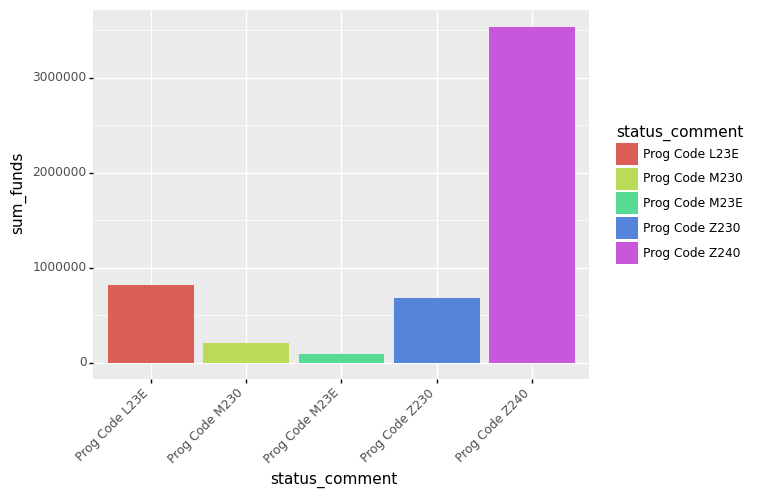

<ggplot: (8758801595130)>

In [39]:
(df >> filter(_.agency.str.contains("City & County Of San Francisco, Mta/Parking"),
             _.project_no == "6328(082)",
             _.prepared_y =='2016-01-01')
    >> group_by(_.status_comment)
    >> summarize(sum_funds = _.total_requested.sum())
    >> ggplot(aes("status_comment", "sum_funds", fill="status_comment")) + geom_col() + theme(axis_text_x = element_text(angle = 45 , hjust=1))
)

##### 2. Napa County

* 6429(023) / 2018-01-01

In [40]:
df >> filter(_.agency.str.contains("Napa County"),
             _.project_no == "6429(023)",
             _.prepared_y =='2018-01-01')

,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
1692,FTA Transferred,FTASTPL,6429(023),Napa County Transportation Planning Agency,2018-04-05,2018-04-05,2018-04-05,2018-05-04,2018-05-07,40000.00,0.00,40000.00,Prog Code L230,6429,4,FTA transferred on 5/7/2018,NaN,29.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6429,23,True,2018-04-01,2018-01-01
1693,FTA Transferred,FTASTPL,6429(023),Napa County Transportation Planning Agency,2018-04-05,2018-04-05,2018-04-05,2018-05-04,2018-05-07,36579.34,0.00,36579.34,Prog Code L230,6429,4,FTA transferred on 5/7/2018,NaN,29.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6429,23,True,2018-04-01,2018-01-01
1694,FTA Transferred,FTASTPL,6429(023),Napa County Transportation Planning Agency,2018-04-05,2018-04-05,2018-04-05,2018-05-04,2018-05-07,2992.04,0.00,2992.04,Prog Code L230,6429,4,FTA transferred on 5/7/2018,NaN,29.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6429,23,True,2018-04-01,2018-01-01
1695,FTA Transferred,FTASTPL,6429(023),Napa County Transportation Planning Agency,2018-04-05,2018-04-05,2018-04-05,2018-05-04,2018-05-07,34226.84,0.00,34226.84,Prog Code L23E,6429,4,FTA transferred on 5/7/2018,NaN,29.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6429,23,True,2018-04-01,2018-01-01
1696,FTA Transferred,FTASTPL,6429(023),Napa County Transportation Planning Agency,2018-04-05,2018-04-05,2018-04-05,2018-05-04,2018-05-07,19844.41,0.00,19844.41,Prog Code L23E,6429,4,FTA transferred on 5/7/2018,NaN,29.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6429,23,True,2018-04-01,2018-01-01
1697,FTA Transferred,FTASTPL,6429(023),Napa County Transportation Planning Agency,2018-04-05,2018-04-05,2018-04-05,2018-05-04,2018-05-07,19501.56,0.00,19501.56,Prog Code L23E,6429,4,FTA transferred on 5/7/2018,NaN,29.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6429,23,True,2018-04-01,2018-01-01
1698,FTA Transferred,FTASTPL,6429(023),Napa County Transportation Planning Agency,2018-04-05,2018-04-05,2018-04-05,2018-05-04,2018-05-07,127042.68,0.00,127042.68,Prog Code L23E,6429,4,FTA transferred on 5/7/2018,NaN,29.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6429,23,True,2018-04-01,2018-01-01
1699,FTA Transferred,FTASTPL,6429(023),Napa County Transportation Planning Agency,2018-04-05,2018-04-05,2018-04-05,2018-05-04,2018-05-07,89685.61,0.00,89685.61,Prog Code M23E,6429,4,FTA transferred on 5/7/2018,NaN,29.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6429,23,True,2018-04-01,2018-01-01
1700,FTA Transferred,FTASTPL,6429(023),Napa County Transportation Planning Agency,2018-04-05,2018-04-05,2018-04-05,2018-05-04,2018-05-07,112721.92,0.00,112721.92,Prog Code M23E,6429,4,FTA transferred on 5/7/2018,NaN,29.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6429,23,True,2018-04-01,2018-01-01
1701,FTA Transferred,FTASTPL,6429(023),Napa County Transportation Planning Agency,2018-04-05,2018-04-05,2018-04-05,2018-05-04,2018-05-07,24536.60,0.00,24536.60,Prog Code M23E,6429,4,FTA transferred on 5/7/2018,NaN,29.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,MTC,NaN,6429,23,True,2018-04-01,2018-01-01


In [41]:
# agian, not much infomation... 
# we have a program code of FTASTPL but no other descriptions

In [42]:
(df >> filter(_.agency.str.contains("Napa County"),
             _.project_no == "6429(023)",
             _.prepared_y =='2018-01-01')
    >> count(_.status_comment)
)

,status_comment,n
0,Prog Code L230,3
1,Prog Code L23E,4
2,Prog Code M23E,3


In [43]:
(df >> filter(_.agency.str.contains("Napa County"),
             _.project_no == "6429(023)",
             _.prepared_y =='2018-01-01')
    >> summarize(sum_funds = _.total_requested.sum())
)

,sum_funds
0,507131.00


In [44]:
(df >> filter(_.agency.str.contains("Napa County"),
             _.project_no == "6429(023)",
             _.prepared_y =='2018-01-01')
    >> group_by(_.status_comment)
    >> summarize(sum_funds2 = _.total_requested.sum())
)

,status_comment,sum_funds2
0,Prog Code L230,79571.38
1,Prog Code L23E,200615.49
2,Prog Code M23E,226944.13


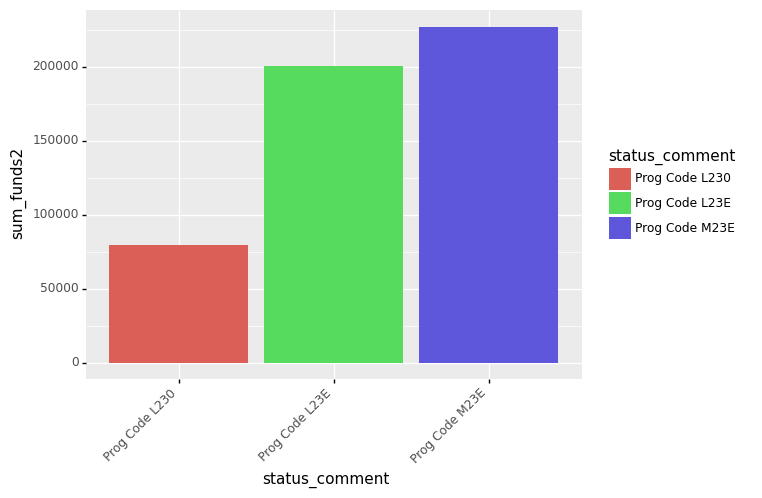

<ggplot: (8758801601350)>

In [45]:
(df >> filter(_.agency.str.contains("Napa County"),
             _.project_no == "6429(023)",
             _.prepared_y =='2018-01-01')
    >> group_by(_.status_comment)
    >> summarize(sum_funds2 = _.total_requested.sum())
    >> ggplot(aes("status_comment", "sum_funds2", fill="status_comment")) + geom_col() + theme(axis_text_x = element_text(angle = 45 , hjust=1))
)


#####  3. Access Services
* 6312(022) / 2016-01-01
* 6312(027) / 2019-01-01

In [46]:
(df >> filter(_.agency.str.contains("Access Services"),
             _.project_no == "6312(022)",
             _.prepared_y =='2016-01-01')
)

,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
7061,FTA Transferred,FTASTPL,6312(022),Access Services,2016-03-02,2016-03-02,2016-03-02,2016-03-30,2016-04-05,4000000.00,0.00,4000000.00,Prog Code L23R,6312,7,FTA transferred on 4/5/2016,0.00,28.00,6.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,22,True,2016-03-01,2016-01-01
7062,FTA Transferred,FTASTPL,6312(022),Access Services,2016-03-02,2016-03-02,2016-03-02,2016-03-30,2016-04-05,6000000.00,0.00,6000000.00,Prog Code M230,6312,7,FTA transferred on 4/5/2016,0.00,28.00,6.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,22,True,2016-03-01,2016-01-01
7063,FTA Transferred,FTASTPL,6312(022),Access Services,2016-03-02,2016-03-02,2016-03-02,2016-03-30,2016-04-05,2300000.00,0.00,2300000.00,Prog Code M230,6312,7,FTA transferred on 4/5/2016,0.00,28.00,6.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,22,True,2016-03-01,2016-01-01
7064,FTA Transferred,FTASTPL,6312(022),Access Services,2016-03-02,2016-03-02,2016-03-02,2016-03-30,2016-04-05,51000000.00,0.00,51000000.00,Prog Code Z230,6312,7,FTA transferred on 4/5/2016,0.00,28.00,6.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,22,True,2016-03-01,2016-01-01
7150,FTA Transferred,FTASTPL,6312(022),Access Services,2016-03-02,2016-03-02,2016-03-02,2016-03-14,2016-03-18,6000000.00,0.00,6000000.00,Prog Code M230,6312,7,FTA transferred on 3/18/2016,0.00,12.00,4.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,22,True,2016-03-01,2016-01-01
7151,FTA Transferred,FTASTPL,6312(022),Access Services,2016-03-02,2016-03-02,2016-03-02,2016-03-14,2016-03-18,2300000.00,0.00,2300000.00,Prog Code M230,6312,7,FTA transferred on 3/18/2016,0.00,12.00,4.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,22,True,2016-03-01,2016-01-01
7152,FTA Transferred,FTASTPL,6312(022),Access Services,2016-03-02,2016-03-02,2016-03-02,2016-03-14,2016-03-18,51000000.00,0.00,51000000.00,Prog Code Z230,6312,7,FTA transferred on 3/18/2016,0.00,12.00,4.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,22,True,2016-03-01,2016-01-01


In [47]:
(df >> filter(_.agency.str.contains("Access Services"),
             _.project_no == "6312(022)",
             _.prepared_y =='2016-01-01')
    >> count(_.status_comment)
)

,status_comment,n
0,Prog Code L23R,1
1,Prog Code M230,4
2,Prog Code Z230,2


In [48]:
(df >> filter(_.agency.str.contains("Access Services"),
             _.project_no == "6312(022)",
             _.prepared_y =='2016-01-01')
    >> group_by(_.status_comment)
    >> summarize(sumfunds=_.total_requested.sum())
)

,status_comment,sumfunds
0,Prog Code L23R,4000000.00
1,Prog Code M230,16600000.00
2,Prog Code Z230,102000000.00


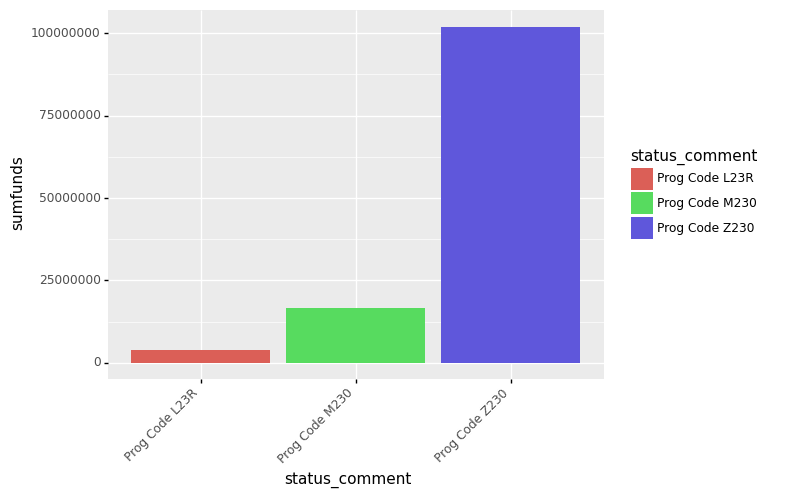

<ggplot: (8758801586399)>

In [49]:
(df >> filter(_.agency.str.contains("Access Services"),
             _.project_no == "6312(022)",
             _.prepared_y =='2016-01-01')
    >> group_by(_.status_comment)
    >> summarize(sumfunds=_.total_requested.sum())
    >> ggplot(aes("status_comment", "sumfunds", fill="status_comment")) + geom_col() + theme(axis_text_x = element_text(angle = 45 , hjust=1))
)

In [50]:
(df >> filter(_.agency.str.contains("Access Services"),
             _.project_no == "6312(027)",
             _.prepared_y =='2019-01-01')
)

,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
14317,FTA Transferred,FTASTPL,6312(027),Access Services,2019-04-08,2019-04-08,2019-04-08,2019-07-09,2019-07-10,39708454.06,0.00,39708454.06,Prog Code Z230,6312,7,FTA transferred on 7/10/2019,NaN,92.00,1.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,27,True,2019-04-01,2019-01-01
14318,FTA Transferred,FTASTPL,6312(027),Access Services,2019-04-08,2019-04-08,2019-04-08,2019-07-09,2019-07-10,1586162.94,0.00,1586162.94,Prog Code Z230,6312,7,FTA transferred on 7/10/2019,NaN,92.00,1.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6312,27,True,2019-04-01,2019-01-01


In [51]:
(df >> filter(_.agency.str.contains("Access Services"),
             _.project_no == "6312(027)",
             _.prepared_y =='2019-01-01')
    >> count(_.status_comment)
)

,status_comment,n
0,Prog Code Z230,2


In [52]:
(df >> filter(_.agency.str.contains("Access Services"),
             _.project_no == "6312(027)",
             _.prepared_y =='2019-01-01')
    >> group_by(_.status_comment)
    >> summarize(sumfunds=_.total_requested.sum())
)

,status_comment,sumfunds
0,Prog Code Z230,41294617.00


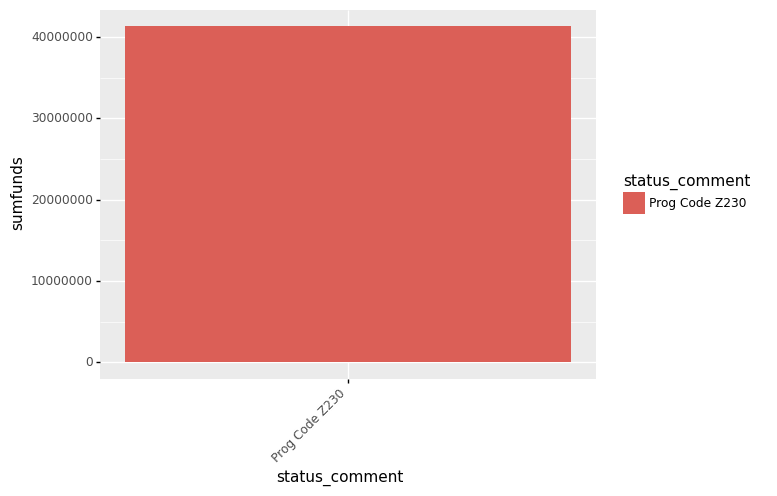

<ggplot: (8758801586417)>

In [53]:
(df >> filter(_.agency.str.contains("Access Services"),
             _.project_no == "6312(027)",
             _.prepared_y =='2019-01-01')
    >> group_by(_.status_comment)
    >> summarize(sumfunds=_.total_requested.sum())
    >> ggplot(aes("status_comment", "sumfunds", fill="status_comment")) + geom_col() + theme(axis_text_x = element_text(angle = 45 , hjust=1))
)

#####  4. Los Angeles County MTA 

* 6065(199) / 2015-01-01
* 6065(225) / 2018-01-01
* 6065(235) / 2019-01-01

In [54]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(199)",
             _.prepared_y =='2015-01-01')
)

,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
8492,FTA Transferred,FTACML,6065(199),Los Angeles County Metropolitan Transportation...,2015-07-15,2015-07-15,2015-07-15,2015-08-06,2015-08-11,723000.00,0.00,723000.00,Prog Code M400,6065,7,FTA transferred on 8/11/2015,0.00,22.00,5.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,199,True,2015-07-01,2015-01-01
8493,FTA Transferred,FTACML,6065(199),Los Angeles County Metropolitan Transportation...,2015-07-15,2015-07-15,2015-07-15,2015-08-06,2015-08-11,542000.00,0.00,542000.00,Prog Code M400,6065,7,FTA transferred on 8/11/2015,0.00,22.00,5.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,199,True,2015-07-01,2015-01-01
8494,FTA Transferred,FTACML,6065(199),Los Angeles County Metropolitan Transportation...,2015-07-15,2015-07-15,2015-07-15,2015-08-06,2015-08-11,878000.00,0.00,878000.00,Prog Code M400,6065,7,FTA transferred on 8/11/2015,0.00,22.00,5.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,199,True,2015-07-01,2015-01-01
8495,FTA Transferred,FTACML,6065(199),Los Angeles County Metropolitan Transportation...,2015-07-15,2015-07-15,2015-07-15,2015-08-06,2015-08-11,220000.00,0.00,220000.00,Prog Code M400,6065,7,FTA transferred on 8/11/2015,0.00,22.00,5.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,199,True,2015-07-01,2015-01-01
8496,FTA Transferred,FTACML,6065(199),Los Angeles County Metropolitan Transportation...,2015-07-15,2015-07-15,2015-07-15,2015-08-06,2015-08-11,865000.00,0.00,865000.00,Prog Code M400,6065,7,FTA transferred on 8/11/2015,0.00,22.00,5.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,199,True,2015-07-01,2015-01-01
8497,FTA Transferred,FTACML,6065(199),Los Angeles County Metropolitan Transportation...,2015-07-15,2015-07-15,2015-07-15,2015-08-06,2015-08-11,1727000.00,0.00,1727000.00,Prog Code M400,6065,7,FTA transferred on 8/11/2015,0.00,22.00,5.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,199,True,2015-07-01,2015-01-01
8498,FTA Transferred,FTACML,6065(199),Los Angeles County Metropolitan Transportation...,2015-07-15,2015-07-15,2015-07-15,2015-08-06,2015-08-11,309000.00,0.00,309000.00,Prog Code M400,6065,7,FTA transferred on 8/11/2015,0.00,22.00,5.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,199,True,2015-07-01,2015-01-01
8499,FTA Transferred,FTACML,6065(199),Los Angeles County Metropolitan Transportation...,2015-07-15,2015-07-15,2015-07-15,2015-08-06,2015-08-11,424000.00,0.00,424000.00,Prog Code M400,6065,7,FTA transferred on 8/11/2015,0.00,22.00,5.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,199,True,2015-07-01,2015-01-01
8500,FTA Transferred,FTACML,6065(199),Los Angeles County Metropolitan Transportation...,2015-07-15,2015-07-15,2015-07-15,2015-08-06,2015-08-11,1265000.00,0.00,1265000.00,Prog Code M400,6065,7,FTA transferred on 8/11/2015,0.00,22.00,5.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,199,True,2015-07-01,2015-01-01


In [55]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(199)",
             _.prepared_y =='2015-01-01')
    >> count(_.status_comment)
)

,status_comment,n
0,Prog Code M400,9


In [56]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(199)",
             _.prepared_y =='2015-01-01')
    >> group_by(_.status_comment)
    >> summarize(sum_funds3= _.total_requested.sum())
)

,status_comment,sum_funds3
0,Prog Code M400,6953000.00


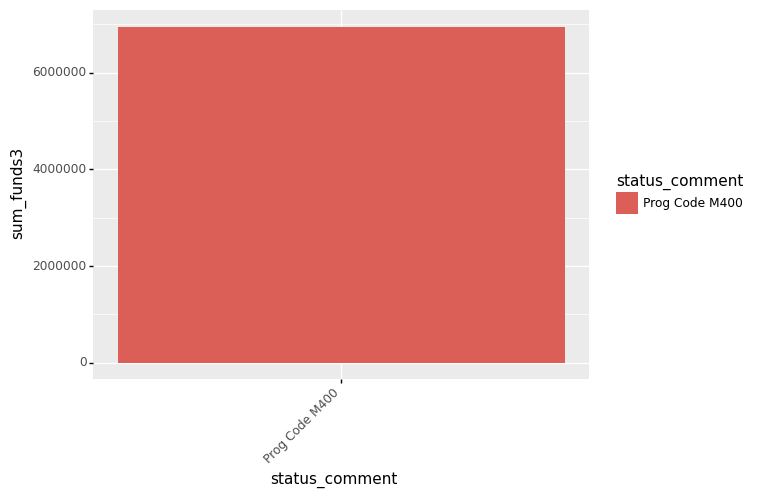

<ggplot: (8758801497739)>

In [57]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(199)",
             _.prepared_y =='2015-01-01')
    >> group_by(_.status_comment)
    >> summarize(sum_funds3= _.total_requested.sum())
    >> ggplot(aes("status_comment", "sum_funds3", fill="status_comment")) + geom_col() + theme(axis_text_x = element_text(angle = 45 , hjust=1))
)

In [58]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(225)",
             _.prepared_y =='2018-01-01')
)

,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
723,FTA Transferred,FTAATPL,6065(225),Los Angeles County Metropolitan Transportation...,2018-05-31,2018-05-31,2018-05-31,2018-07-26,2018-08-24,683000.00,0.00,683000.00,Prog Code Z300,6065,7,FTA transferred on 8/24/2018,NaN,56.00,29.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,225,True,2018-05-01,2018-01-01
724,FTA Transferred,FTAATPL,6065(225),Los Angeles County Metropolitan Transportation...,2018-05-31,2018-05-31,2018-05-31,2018-07-26,2018-08-24,260605.00,0.00,260605.00,Prog Code Z301,6065,7,FTA transferred on 8/24/2018,NaN,56.00,29.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,225,True,2018-05-01,2018-01-01
725,FTA Transferred,FTAATPL,6065(225),Los Angeles County Metropolitan Transportation...,2018-05-31,2018-05-31,2018-05-31,2018-07-26,2018-08-24,243263.00,0.00,243263.00,Prog Code Z301,6065,7,FTA transferred on 8/24/2018,NaN,56.00,29.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,225,True,2018-05-01,2018-01-01
726,FTA Transferred,FTAATPL,6065(225),Los Angeles County Metropolitan Transportation...,2018-05-31,2018-05-31,2018-05-31,2018-07-26,2018-08-24,39939.00,0.00,39939.00,Prog Code Z301,6065,7,FTA transferred on 8/24/2018,NaN,56.00,29.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,225,True,2018-05-01,2018-01-01
727,FTA Transferred,FTAATPL,6065(225),Los Angeles County Metropolitan Transportation...,2018-05-31,2018-05-31,2018-05-31,2018-07-26,2018-08-24,315546.00,0.00,315546.00,Prog Code Z301,6065,7,FTA transferred on 8/24/2018,NaN,56.00,29.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,225,True,2018-05-01,2018-01-01
728,FTA Transferred,FTAATPL,6065(225),Los Angeles County Metropolitan Transportation...,2018-05-31,2018-05-31,2018-05-31,2018-07-26,2018-08-24,320849.00,0.00,320849.00,Prog Code Z301,6065,7,FTA transferred on 8/24/2018,NaN,56.00,29.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,225,True,2018-05-01,2018-01-01
729,FTA Transferred,FTAATPL,6065(225),Los Angeles County Metropolitan Transportation...,2018-05-31,2018-05-31,2018-05-31,2018-07-26,2018-08-24,239192.00,0.00,239192.00,Prog Code Z301,6065,7,FTA transferred on 8/24/2018,NaN,56.00,29.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,225,True,2018-05-01,2018-01-01
730,FTA Transferred,FTAATPL,6065(225),Los Angeles County Metropolitan Transportation...,2018-05-31,2018-05-31,2018-05-31,2018-07-26,2018-08-24,197545.00,0.00,197545.00,Prog Code Z301,6065,7,FTA transferred on 8/24/2018,NaN,56.00,29.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,225,True,2018-05-01,2018-01-01
731,FTA Transferred,FTAATPL,6065(225),Los Angeles County Metropolitan Transportation...,2018-05-31,2018-05-31,2018-05-31,2018-07-26,2018-08-24,164061.00,0.00,164061.00,Prog Code Z301,6065,7,FTA transferred on 8/24/2018,NaN,56.00,29.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,225,True,2018-05-01,2018-01-01


In [59]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(225)",
             _.prepared_y =='2018-01-01')
    >> count(_.status_comment)
)

,status_comment,n
0,Prog Code Z300,1
1,Prog Code Z301,8


In [60]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(225)",
             _.prepared_y =='2018-01-01')
    >> group_by(_.status_comment)
    >> summarize(sumfunds = _.total_requested.sum())
)

,status_comment,sumfunds
0,Prog Code Z300,683000.00
1,Prog Code Z301,1781000.00


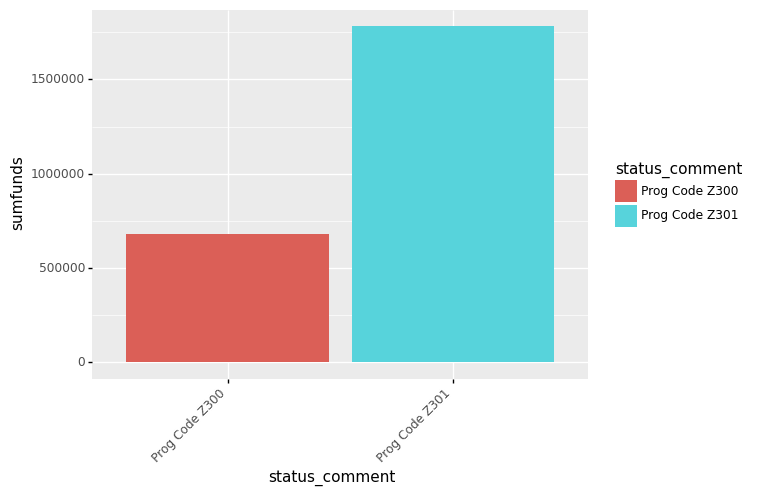

<ggplot: (8758779011347)>

In [61]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(225)",
             _.prepared_y =='2018-01-01')
    >> group_by(_.status_comment)
    >> summarize(sumfunds = _.total_requested.sum())
    >> ggplot(aes("status_comment", "sumfunds", fill="status_comment")) + geom_col() + theme(axis_text_x = element_text(angle = 45 , hjust=1))
)

In [62]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(235)",
             _.prepared_y =='2019-01-01')
)

,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
14313,FTA Transferred,FTACML,6065(235),Los Angeles County Metropolitan Transportation...,2019-04-05,2019-04-05,2019-04-05,2019-07-09,2019-07-10,5039724.82,0.00,5039724.82,Prog Code Z400,6065,7,FTA transferred on 7/10/2019,NaN,95.00,1.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,235,True,2019-04-01,2019-01-01
14314,FTA Transferred,FTACML,6065(235),Los Angeles County Metropolitan Transportation...,2019-04-05,2019-04-05,2019-04-05,2019-07-09,2019-07-10,1018434.71,0.00,1018434.71,Prog Code Z400,6065,7,FTA transferred on 7/10/2019,NaN,95.00,1.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SCAG,NaN,6065,235,True,2019-04-01,2019-01-01


In [63]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(235)",
             _.prepared_y =='2019-01-01')
    >> count(_.status_comment)
)

,status_comment,n
0,Prog Code Z400,2


In [64]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(235)",
             _.prepared_y =='2019-01-01')
    >> group_by(_.status_comment)
    >> summarize(sumfunds=_.total_requested.sum())
)

,status_comment,sumfunds
0,Prog Code Z400,6058159.53


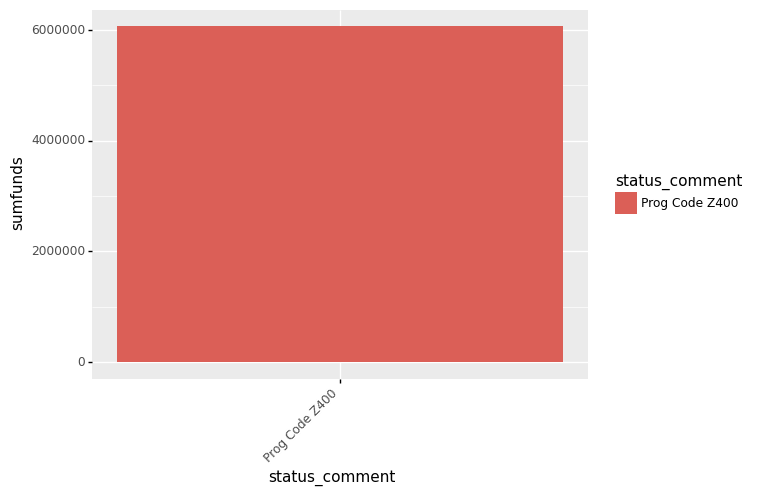

<ggplot: (8758797229562)>

In [65]:
(df >> filter(_.agency.str.contains("Los Angeles County"),
             _.project_no == "6065(235)",
             _.prepared_y =='2019-01-01')
    >> group_by(_.status_comment)
    >> summarize(sumfunds=_.total_requested.sum())
    >> ggplot(aes("status_comment", "sumfunds", fill="status_comment")) + geom_col() + theme(axis_text_x = element_text(angle = 45 , hjust=1))
)



#####  5. San Diego Metropolitan Tranit System

* 7503(001)  / 2020-01-01

In [66]:
(df >> filter(_.agency.str.contains("San Diego Metropolitan Tranit System"),
             _.project_no == "7503(001)",
             _.prepared_y =='2020-01-01'))


,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
17001,FTA Transferred,FTASTPL,7503(001),San Diego Metropolitan Tranit System,2020-07-03,2020-07-03,2020-07-03,2020-07-31,2020-08-03,9342958.12,0.00,9342958.12,Prog Code Z230,7503,11,FTA transferred on 8/3/2020,NaN,28.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,NON-MPO,NaN,7503,1,True,2020-07-01,2020-01-01
17002,FTA Transferred,FTASTPL,7503(001),San Diego Metropolitan Tranit System,2020-07-03,2020-07-03,2020-07-03,2020-07-31,2020-08-03,0.65,0.00,0.65,Prog Code H230,7503,11,FTA transferred on 8/3/2020,NaN,28.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,NON-MPO,NaN,7503,1,True,2020-07-01,2020-01-01
17003,FTA Transferred,FTASTPL,7503(001),San Diego Metropolitan Tranit System,2020-07-03,2020-07-03,2020-07-03,2020-07-31,2020-08-03,1312.48,0.00,1312.48,Prog Code L230,7503,11,FTA transferred on 8/3/2020,NaN,28.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,NON-MPO,NaN,7503,1,True,2020-07-01,2020-01-01
17004,FTA Transferred,FTASTPL,7503(001),San Diego Metropolitan Tranit System,2020-07-03,2020-07-03,2020-07-03,2020-07-31,2020-08-03,0.51,0.00,0.51,Prog Code L23E,7503,11,FTA transferred on 8/3/2020,NaN,28.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,NON-MPO,NaN,7503,1,True,2020-07-01,2020-01-01
17005,FTA Transferred,FTASTPL,7503(001),San Diego Metropolitan Tranit System,2020-07-03,2020-07-03,2020-07-03,2020-07-31,2020-08-03,12354.63,0.00,12354.63,Prog Code L23R,7503,11,FTA transferred on 8/3/2020,NaN,28.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,NON-MPO,NaN,7503,1,True,2020-07-01,2020-01-01
17006,FTA Transferred,FTASTPL,7503(001),San Diego Metropolitan Tranit System,2020-07-03,2020-07-03,2020-07-03,2020-07-31,2020-08-03,0.12,0.00,0.12,Prog Code Q230,7503,11,FTA transferred on 8/3/2020,NaN,28.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,NON-MPO,NaN,7503,1,True,2020-07-01,2020-01-01
17007,FTA Transferred,FTASTPL,7503(001),San Diego Metropolitan Tranit System,2020-07-03,2020-07-03,2020-07-03,2020-07-31,2020-08-03,243373.49,0.00,243373.49,Prog Code 33C0,7503,11,FTA transferred on 8/3/2020,NaN,28.00,3.00,NaN,NaN,FTA Transfer,1,NaT,NaT,NON-MPO,NaN,7503,1,True,2020-07-01,2020-01-01


In [67]:
(df >> filter(_.agency.str.contains("San Diego Metropolitan Tranit System"),
             _.project_no == "7503(001)",
             _.prepared_y =='2020-01-01')
    >> count(_.status_comment)
)


,status_comment,n
0,Prog Code 33C0,1
1,Prog Code H230,1
2,Prog Code L230,1
3,Prog Code L23E,1
4,Prog Code L23R,1
5,Prog Code Q230,1
6,Prog Code Z230,1


In [68]:
(df >> filter(_.agency.str.contains("San Diego Metropolitan Tranit System"),
             _.project_no == "7503(001)",
             _.prepared_y =='2020-01-01')
    >> group_by(_.status_comment)
    >> summarize(sum_funds4=_.total_requested.sum())
)

,status_comment,sum_funds4
0,Prog Code 33C0,243373.49
1,Prog Code H230,0.65
2,Prog Code L230,1312.48
3,Prog Code L23E,0.51
4,Prog Code L23R,12354.63
5,Prog Code Q230,0.12
6,Prog Code Z230,9342958.12


In [69]:
# three program coodes under a dollar...?

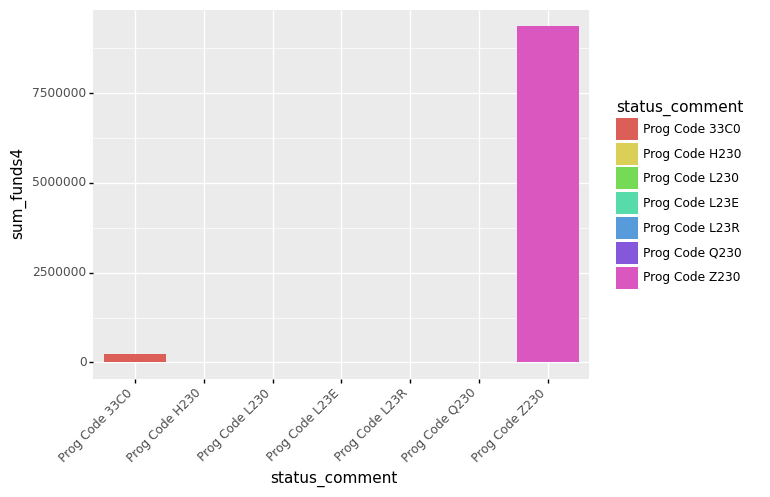

<ggplot: (8758778933625)>

In [70]:
(df >> filter(_.agency.str.contains("San Diego Metropolitan Tranit System"),
             _.project_no == "7503(001)",
             _.prepared_y =='2020-01-01')
    >> group_by(_.status_comment)
    >> summarize(sum_funds4=_.total_requested.sum())
    >> ggplot(aes("status_comment", "sum_funds4", fill="status_comment")) + geom_col() + theme(axis_text_x = element_text(angle = 45 , hjust=1))
)

#### Trying another approach for non-FTA oblgiations

In [71]:
(df
    >> group_by(_.prefix, _.agency, _.project_no)
    >> count(_.prepared_y) 
    >> arrange(-_.n)
    >> filter(_.prefix.str.contains('FTA')== False)
    >> filter(_.n > 3)
)

,prefix,agency,project_no,prepared_y,n
9481,HP21L,Compton,5078(012),2018-01-01,5
14407,STP,Brawley,5167(037),2018-01-01,5
15036,STP,Huron,5305(014),2014-01-01,5
16750,STPLER,Calipatria,5243(002),2016-01-01,5
648,ATP,Fresno,5060(291),2015-01-01,4
1084,ATPCML,South Lake Tahoe,5398(012),2020-01-01,4
1299,BHLS,"Golden Gate Bridge, Highway And Transportation...",6003(051),2021-01-01,4
6035,CML,Parlier,5252(021),2018-01-01,4
7506,CMSTPLNI,Sacramento Area Council Of Governments,6085(080),2020-01-01,4
13448,RPSTP,Humboldt County,5904(106),2014-01-01,4


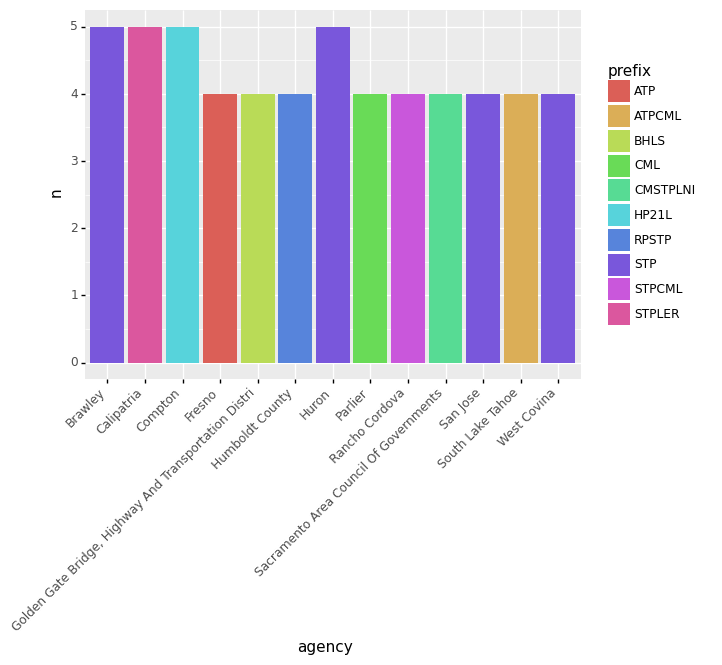

<ggplot: (8758778934833)>

In [72]:
(df
    >> group_by(_.prefix, _.agency, _.project_no)
    >> count(_.prepared_y) 
    >> arrange(-_.n)
    >> filter(_.prefix.str.contains('FTA')== False)
    >> filter(_.n > 3)
    >> ggplot(aes("agency", "n", fill="prefix")) + geom_col() + theme(axis_text_x = element_text(angle = 45 , hjust=1))
)

In [73]:
(df
    >> group_by(_.prefix, _.agency, _.project_no)
    >> count(_.prepared_y) 
    >> arrange(-_.n)
    >> filter(_.prefix.str.contains('FTA')== False)
    >> filter(_.n > 4)
)

,prefix,agency,project_no,prepared_y,n
9481,HP21L,Compton,5078(012),2018-01-01,5
14407,STP,Brawley,5167(037),2018-01-01,5
15036,STP,Huron,5305(014),2014-01-01,5
16750,STPLER,Calipatria,5243(002),2016-01-01,5


In [74]:
# exploring these obligations in hopes that these have more information 

In [75]:
(df
    >> filter(_.agency == 'San Joaquin Regional Rail Commission',
             _.project_no == '6262(020)',
             _.prepared_y == '2019-01-01')
)

,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
14476,FTA Transferred,FTFERPL16,6262(020),San Joaquin Regional Rail Commission,2019-05-29,2019-05-29,2019-05-29,2019-08-05,2019-08-07,5439847.00,0.00,5439847.00,Prog Code RPS9,6262,10,FTA transferred on 8/7/2019,NaN,68.00,2.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SJCG,NaN,6262,20,True,2019-05-01,2019-01-01
14477,FTA Transferred,FTFERPL16,6262(020),San Joaquin Regional Rail Commission,2019-05-29,2019-05-29,2019-05-29,2019-08-05,2019-08-07,1439840.00,0.00,1439840.00,Prog Code RPS9,6262,10,FTA transferred on 8/7/2019,NaN,68.00,2.00,NaN,NaN,FTA Transfer,1,NaT,NaT,SJCG,NaN,6262,20,True,2019-05-01,2019-01-01


In [76]:
# These are also FTA Transfers, program codes are all the same

In [77]:
(df
    >> filter(_.agency == 'Compton',
             _.project_no == '5078(012)',
             _.prepared_y == '2018-01-01')
)

,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
801,Obligated,HP21L,5078(012),Compton,2018-08-08,2018-08-08,2018-08-08,2018-08-08,2018-08-14,13.85,0.00,0.00,Authorized,5078,7,E-76 approved on,NaN,0.00,6.00,NaN,Citywide,Traf. Signal System Upgrade &,7,NaT,NaT,SCAG,NaN,5078,12,True,2018-08-01,2018-01-01
852,Obligated,HP21L,5078(012),Compton,2018-07-25,2018-07-25,2018-07-25,2018-07-31,2018-08-07,0.00,0.00,0.00,Authorized,5078,7,E-76 approved on,NaN,6.00,7.00,NaN,Citywide,Traf. Signal System Upgrade &,6,NaT,NaT,SCAG,NaN,5078,12,True,2018-07-01,2018-01-01
1568,Obligated,HP21L,5078(012),Compton,2018-05-09,2018-05-09,2018-05-09,2018-05-09,2018-05-18,0.00,0.00,1275883.59,Authorized,5078,7,E-76 approved on,NaN,0.00,9.00,NaN,Citywide,Traf. Signal System Upgrade &,5,NaT,NaT,SCAG,NaN,5078,12,True,2018-05-01,2018-01-01
2101,Obligated,HP21L,5078(012),Compton,2018-03-26,2018-03-26,2018-03-26,2018-03-26,2018-03-28,-647759.57,0.00,-648816.92,Authorized,5078,7,E-76 approved on,NaN,0.00,2.00,NaN,Citywide,Traf. Signal System Upgrade &,4,NaT,NaT,SCAG,NaN,5078,12,True,2018-03-01,2018-01-01
13954,Obligated,HP21L,5078(012),Compton,2018-08-31,2018-08-31,2018-08-31,2018-12-31,2019-01-03,0.00,0.00,0.00,Authorized,5078,7,E-76 approved on,NaN,122.00,3.00,NaN,Citywide,Traf. Signal System Upgrade &,8,NaT,NaT,SCAG,NaN,5078,12,True,2018-08-01,2018-01-01


In [78]:
#these have different sequences, projects city-wide

In [79]:
(df
    >> filter(_.agency == 'Brawley',
             _.project_no == '5167(037)',
             _.prepared_y == '2018-01-01')
)

,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
457,Obligated,STP,5167(037),Brawley,2018-09-28,2018-09-28,2018-09-28,2018-10-10,2018-10-16,-0.15,0.00,0.00,Authorized,5167,11,E-76 approved on,NaN,12.00,6.00,NaN,South Palm Avenue,"Rehabilitate Asphalt, Roadway Overlay, Bicycle...",6,NaT,NaT,SCAG,NaN,5167,37,True,2018-09-01,2018-01-01
986,Obligated,STP,5167(037),Brawley,2018-07-11,2018-07-11,2018-07-11,2018-07-11,2018-07-18,0.00,0.00,0.00,Authorized,5167,11,E-76 approved on,NaN,0.00,7.00,NaN,South Palm Avenue,"Rehabilitate Asphalt, Roadway Overlay, Bicycle...",5,NaT,NaT,SCAG,NaN,5167,37,True,2018-07-01,2018-01-01
1071,Obligated,STP,5167(037),Brawley,2018-07-02,2018-07-02,2018-07-02,2018-07-02,2018-07-10,0.00,0.00,0.00,Authorized,5167,11,E-76 approved on,NaN,0.00,8.00,NaN,South Palm Avenue,"Rehabilitate Asphalt, Roadway Overlay, Bicycle...",4,NaT,NaT,SCAG,NaN,5167,37,True,2018-07-01,2018-01-01
1250,Obligated,STP,5167(037),Brawley,2018-06-25,2018-06-25,2018-06-25,2018-06-25,2018-06-28,0.15,0.00,0.00,Authorized,5167,11,E-76 approved on,NaN,0.00,3.00,NaN,South Palm Avenue,"Rehabilitate Asphalt, Roadway Overlay, Bicycle...",3,NaT,NaT,SCAG,NaN,5167,37,True,2018-06-01,2018-01-01
1572,Obligated,STP,5167(037),Brawley,2018-05-07,2018-05-07,2018-05-07,2018-05-07,2018-05-18,-151665.65,0.00,-171316.15,Authorized,5167,11,E-76 approved on,11.00,0.00,11.00,NaN,South Palm Avenue,"Rehabilitate Asphalt, Roadway Overlay, Bicycle...",2,2018-04-26,2018-05-07,SCAG,NaN,5167,37,True,2018-05-01,2018-01-01


In [80]:
# multiple segment project, no first sequence, and the oblogated amounts are near zero or below zero. 

In [81]:
(df
    >> filter(_.agency == 'Huron',
             _.project_no == '5305(014)',
             _.prepared_y == '2014-01-01')
)

,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
10505,Obligated,STP,5305(014),Huron,2014-10-30,2014-10-30,2014-10-31,2014-11-06,2014-11-07,-27745.00,0.00,-45575.00,Authorized,5305,6,E-76 approved on E-76 approved on,0.00,7.00,1.00,FRE130023,9th Street From 'm' To 'o' Streets,Road Reconstruction (tc),5,NaT,NaT,CFCG,NaN,5305,14,True,2014-10-01,2014-01-01
11096,Obligated,STP,5305(014),Huron,2014-07-16,2014-07-23,2014-07-28,2014-08-05,2014-08-05,350000.00,0.00,367830.00,Authorized,5305,6,E-76 approved on E-76 approved on,7.00,13.00,0.00,FRE130023,9th Street From 'm' To 'o' Streets,Road Reconstruction (tc),4,NaT,NaT,CFCG,NaN,5305,14,True,2014-07-01,2014-01-01
11609,Obligated,STP,5305(014),Huron,2014-06-10,2014-06-10,2014-06-10,2014-06-18,2014-06-20,0.00,0.00,0.00,Authorized,5305,6,E-76 approved on E-76 approved on,0.00,8.00,2.00,FRE130023,9th Street From 'm' To 'o' Streets,Road Reconstruction (tc),3,NaT,NaT,CFCG,NaN,5305,14,True,2014-06-01,2014-01-01
11839,Obligated,STP,5305(014),Huron,2014-05-16,2014-05-16,2014-05-16,2014-05-16,2014-05-19,0.00,0.00,0.00,Authorized,5305,6,E-76 approved on E-76 approved on,0.00,0.00,3.00,FRE130023,9th Street From 'm' To 'o' Streets,Road Reconstruction (tc),2,NaT,NaT,CFCG,NaN,5305,14,True,2014-05-01,2014-01-01
11977,Obligated,STP,5305(014),Huron,2014-04-21,2014-04-21,2014-04-24,2014-04-28,2014-04-29,42000.00,0.00,42000.00,Authorized,5305,6,E-76 approved on E-76 approved on,0.00,7.00,1.00,FRE130023,9th Street From 'm' To 'o' Streets,Road Reconstruction (tc),1,NaT,NaT,CFCG,NaN,5305,14,True,2014-04-01,2014-01-01


In [82]:
#another multi-segment project for road construction 

In [83]:
(df
    >> filter(_.agency == 'San Jose',
             _.project_no == '5005(163)',
             _.prepared_y == '2020-01-01')
)

,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
16421,Obligated,STP,5005(163),San Jose,2020-04-13,2020-05-07,2020-05-11,2020-05-12,2020-05-13,0.00,16642138.00,23471782.00,Authorized,5005,4,E-76 approved on,52.00,5.00,1.00,scl170044,The Project Locations Are: Cherry Avenue From ...,Project Work Includes: Road Rehabilitation; Re...,1,2020-03-16,2020-05-06,MTC,NaN,5005,163,True,2020-04-01,2020-01-01
17073,Obligated,STP,5005(163),San Jose,2020-09-01,2020-09-01,2020-09-02,2020-09-11,2020-09-16,2483075.89,-2483075.89,-0.00,Authorized,5005,4,E-76 approved on,NaN,10.00,5.00,SCL170044,The Project Locations Are: Cherry Avenue From ...,Project Work Includes: Road Rehabilitation; Re...,2,NaT,NaT,MTC,NaN,5005,163,True,2020-09-01,2020-01-01
17462,Obligated,STP,5005(163),San Jose,2020-11-02,2020-11-02,2020-11-06,2020-11-06,2020-11-13,0.00,0.00,-2288474.00,Authorized,5005,4,E-76 approved on,10.00,4.00,7.00,SCL170044,The Project Locations Are: Cherry Avenue From ...,Project Work Includes: Road Rehabilitation; Re...,3,2020-10-23,2020-10-30,MTC,NaN,5005,163,True,2020-11-01,2020-01-01
17836,Obligated,STP,5005(163),San Jose,2020-12-22,2020-12-22,2020-12-28,2020-12-30,2021-01-07,14159062.11,-14159062.11,0.00,Authorized,5005,4,E-76 approved on,1.00,8.00,8.00,SCL170044,The Project Locations Are: Cherry Avenue From ...,Project Work Includes: Road Rehabilitation; Re...,4,2020-12-21,2020-12-22,MTC,NaN,5005,163,True,2020-12-01,2020-01-01


In [84]:
# another double entry- possibly a refund (?) since it is negative funds.


In [85]:
(df
    >> filter(_.agency == 'Calipatria',
             _.project_no == '5243(002)',
             _.prepared_y == '2016-01-01')
)

,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
6024,Obligated,STPLER,5243(002),Calipatria,2016-08-03,2016-08-03,2016-08-03,2016-08-03,2016-08-11,0.00,0.00,0.00,Authorized,5243,11,E-76 approved on Prepared on 10/12/2015,0.00,0.00,8.00,NaN,On Sr-111 And Sr-115 In Calipatria,"Beautification, Landscaping, C",9,NaT,NaT,SCAG,NaN,5243,2,True,2016-08-01,2016-01-01
6516,Obligated,STPLER,5243(002),Calipatria,2016-06-03,2016-06-03,2016-06-03,2016-06-03,2016-06-21,0.00,0.00,0.00,Authorized,5243,11,E-76 approved on Prepared on 10/6/2015,0.00,0.00,18.00,NaN,On Sr-111 And Sr-115 In Calipatria,"Beautification, Landscaping, C",8,NaT,NaT,SCAG,NaN,5243,2,True,2016-06-01,2016-01-01
6844,Obligated,STPLER,5243(002),Calipatria,2016-04-22,2016-04-22,2016-04-22,2016-04-22,2016-05-09,0.00,0.00,0.00,Authorized,5243,11,E-76 approved on Prepared on 10/6/2015,0.00,0.00,17.00,NaN,On Sr-111 And Sr-115 In Calipatria,"Beautification, Landscaping, C",7,NaT,NaT,SCAG,NaN,5243,2,True,2016-04-01,2016-01-01
7038,Obligated,STPLER,5243(002),Calipatria,2016-04-05,2016-04-05,2016-04-05,2016-04-05,2016-04-11,0.00,0.00,445709.54,Authorized,5243,11,E-76 approved on Prepared on 10/12/2015,0.00,0.00,6.00,NaN,On Sr-111 And Sr-115 In Calipatria,"Beautification, Landscaping, C",6,NaT,NaT,SCAG,NaN,5243,2,True,2016-04-01,2016-01-01
7072,Obligated,STPLER,5243(002),Calipatria,2016-03-23,2016-03-23,2016-03-23,2016-03-23,2016-04-01,0.00,0.00,0.00,Authorized,5243,11,E-76 approved on Prepared on 10/12/2015,0.00,0.00,9.00,NaN,On Sr-111 And Sr-115 In Calipatria,"Beautification, Landscaping, C",5,NaT,NaT,SCAG,NaN,5243,2,True,2016-03-01,2016-01-01


In [86]:
# intersting to see another group of obligations have no funds attached to them. 


### Filtering by agency and year and type of work

In [87]:
(df
    >> group_by(_.agency)
    >> count(_.prepared_y) 
    >> arrange(-_.n)
    >> filter(_.n >= 50)
)

,agency,prepared_y,n
1158,Humboldt County,2018-01-01,171
1159,Humboldt County,2019-01-01,147
1519,Los Angeles,2014-01-01,110
2860,Santa Cruz County,2018-01-01,107
2861,Santa Cruz County,2019-01-01,104
1520,Los Angeles,2015-01-01,85
1735,Modesto,2018-01-01,85
1160,Humboldt County,2020-01-01,84
952,Fresno,2015-01-01,83
1533,Los Angeles County,2019-01-01,77


In [88]:
(df
    >> group_by(_.agency, _.type_of_work, _.prepared_y)
    >> count(_.prefix) 
    >> arrange(-_.n)
    >> filter(_.n > 10)
)

,agency,type_of_work,prepared_y,prefix,n
4302,Humboldt County,Storm Damage Restoration,2018-01-01,ER,84
4211,Humboldt County,Permanent Restoration,2019-01-01,ER,47
4208,Humboldt County,Permanent Restoration,2018-01-01,ER,36
4209,Humboldt County,Permanent Restoration,2019-01-01,ACST-ER,27
10732,San Bernardino County,Replace Two Lane Timber Bridge With Two Lane B...,2021-01-01,BRLS,18
6901,Mendocino County,Permanent Restoration,2018-01-01,ER,17
3170,Fresno,Ac Overlay (tc),2016-01-01,STP,16
3173,Fresno,Ac Overlay (tc),2019-01-01,STP,16
4214,Humboldt County,Permanent Restoration,2020-01-01,ER,16
4217,Humboldt County,Permanent Restoration,2021-01-01,ER,16


#### Los Angeles Project Locations

In [89]:
df >> filter(_.agency=='Los Angeles') >> count(_.project_location) >> arrange(-_.n) >> filter(_.n>=4)

,project_location,n
252,"Sixth Street Viaduct Over La River, Us 101, An...",13
251,Sixth Street Viaduct Over La River And East Sa...,8
7,"1st St Br Over Glendale/beverly Blvd, Br# 53c0045",5
29,Along Hollywood And Sunset Blbd. Bet'n Gower &...,5
85,"Dolores Huerta Es, 28th Street Es And Quincy J...",5
120,Hyperion Viaduct Over La River Bridge # 53c-1881,5
205,"N. Spring St. Brdg Ovr L.a. Rvr, Bridge # 53c0859",5
105,Fletcher Dr. Over La River; Bridge # 53c-0096,4
112,Highland Park Along Figueroa Between Ave 50 An...,4
201,Menlo Elementary School And West Vernon Elemen...,4


In [90]:
(df >> filter(_.agency=='Los Angeles') 
    >> filter(_.project_location.str.contains('Sixth Street Viaduct')) 
    >> count(_.project_no))

,project_no,n
0,5006(664),8
1,5006(811),6
2,5006(815),4
3,5006(831),3
4,5006(839),9


In [91]:
(df >> filter(_.agency=='Los Angeles') 
    >> filter(_.project_location.str.contains('Sixth Street Viaduct')) 
    >> count(_.prefix))

,prefix,n
0,BRLSZD,30


In [92]:
(df >> filter(_.agency=='Los Angeles') 
    >> filter(_.project_location.str.contains('Sixth Street Viaduct')) 
    >> group_by(_.prepared_y)
    >> count(_.project_no))

,prepared_y,project_no,n
0,2014-01-01,5006(664),2
1,2015-01-01,5006(664),2
2,2015-01-01,5006(811),1
3,2015-01-01,5006(815),1
4,2016-01-01,5006(664),3
5,2016-01-01,5006(811),2
6,2016-01-01,5006(815),2
7,2016-01-01,5006(831),2
8,2016-01-01,5006(839),1
9,2017-01-01,5006(811),2


In [93]:
(df >> filter(_.agency=='Los Angeles') 
    >> filter(_.project_location.str.contains('Sixth Street Viaduct')) 
    >> filter(_.prepared_y == '2016-01-01')
    
)

,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y
4876,Obligated,BRLSZD,5006(664),Los Angeles,2016-10-12,2017-02-13,2017-02-15,2017-02-17,2017-02-27,0.00,-168216336.00,-189720550.00,Authorized,5006,7,E-76 approved on Prepared on 1/27/2017,124.00,4.00,10.00,LA0G104,Sixth Street Viaduct Over La River And East Sa...,Replace Struct Deficient Viaduct With New (tc),12,NaT,NaT,SCAG,NaN,5006,664,True,2016-10-01,2016-01-01
5226,Obligated,BRLSZD,5006(811),Los Angeles,2016-11-10,2016-11-10,2016-11-16,2016-11-23,2016-12-16,-222.00,0.00,356149.00,Authorized,5006,7,E-76 approved on Prepared on 10/6/2015,0.00,13.00,23.00,LA0G104,"Sixth Street Viaduct Over La River, Us 101, An...",Cmgc Package #2 Is For The Viaduct Demolition,3,NaT,NaT,SCAG,NaN,5006,811,True,2016-11-01,2016-01-01
5683,Obligated,BRLSZD,5006(831),Los Angeles,2016-07-07,2016-07-07,2016-09-27,2016-09-27,2016-09-27,5000000.00,-5000000.00,0.00,Authorized,5006,7,E-76 approved on Prepared on 9/29/2016,0.00,82.00,0.00,LA0G104,"Sixth Street Viaduct Over La River, Us 101, An...",This Is Cmgc Package #4 Is For Foundations,2,NaT,NaT,SCAG,NaN,5006,831,True,2016-07-01,2016-01-01
5704,Obligated,BRLSZD,5006(839),Los Angeles,2016-07-14,2016-08-30,2016-09-02,2016-09-19,2016-09-21,0.00,165978040.00,200380703.00,Authorized,5006,7,E-76 approved on Prepared on 9/29/2016,47.00,20.00,2.00,LA0G104,"Sixth Street Viaduct Over La River, Us 101, An...",Cmgc Package #5 Viaduct,1,NaT,NaT,SCAG,NaN,5006,839,True,2016-07-01,2016-01-01
6214,Obligated,BRLSZD,5006(815),Los Angeles,2016-06-24,2016-06-27,2016-06-30,2016-07-05,2016-07-25,-29118.00,0.00,-32890.00,Authorized,5006,7,E-76 approved on Prepared on 10/6/2015,3.00,8.00,20.00,LA0G104,Sixth Street Viaduct Adjacent To New Bent 7,Construction Of Test Pile: Package 3,3,NaT,NaT,SCAG,NaN,5006,815,True,2016-06-01,2016-01-01
6469,Obligated,BRLSZD,5006(664),Los Angeles,2016-05-10,2016-05-31,2016-06-02,2016-06-10,2016-06-22,0.00,-26125154.00,-29509945.00,Authorized,5006,7,E-76 approved on Prepared on 10/6/2015,21.00,10.00,12.00,LA0G104,Sixth Street Viaduct Over La River And East Sa...,Replace Struct Deficient Viaduct With New (tc),11,NaT,NaT,SCAG,NaN,5006,664,True,2016-05-01,2016-01-01
6665,Obligated,BRLSZD,5006(831),Los Angeles,2016-05-05,2016-05-24,2016-05-27,2016-05-27,2016-05-31,0.00,26125154.00,29509945.00,Authorized,5006,7,E-76 approved on Prepared on 10/6/2015,19.00,3.00,4.00,LA0G104,"Sixth Street Viaduct Over La River, Us 101, An...",This Is Cmgc Package #4 Is For Foundations,1,NaT,NaT,SCAG,NaN,5006,831,True,2016-05-01,2016-01-01
6705,Obligated,BRLSZD,5006(811),Los Angeles,2016-04-18,2016-05-04,2016-05-04,2016-05-04,2016-05-27,27827445.00,-27827445.00,0.00,Authorized,5006,7,E-76 approved on Prepared on 10/6/2015,16.00,0.00,23.00,LA0G104,"Sixth Street Viaduct Over La River, Us 101, An...",Cmgc Package #2 Is For The Viaduct Demolition,2,NaT,NaT,SCAG,NaN,5006,811,True,2016-04-01,2016-01-01
6836,Obligated,BRLSZD,5006(815),Los Angeles,2016-04-08,2016-04-18,2016-04-18,2016-04-28,2016-05-10,1455876.00,-1455876.00,0.00,Authorized,5006,7,E-76 approved on Prepared on 10/6/2015,10.00,10.00,12.00,LA0G104,Sixth Street Viaduct Adjacent To New Bent 7,Construction Of Test Pile: Package 3,2,NaT,NaT,SCAG,NaN,5006,815,True,2016-04-01,2016-01-01
7068,Obligated,BRLSZD,5006(664),Los Angeles,2016-03-07,2016-03-11,2016-03-16,2016-03-28,2016-04-01,0.00,-27827445.00,-31432785.00,Authorized,5006,7,E-76 approved on Prepared on 10/12/2015,4.00,17.00,4.00,LA0G104,Sixth Street Viaduct Over La River And East Sa...,Replace Struct Deficient Viaduct With New (tc),10,NaT,NaT,SCAG,NaN,5006,664,True,2016-03-01,2016-01-01


## How many times do the fund request columns equal $0

In [94]:
(df >> mutate(sum_funds = _.fed_requested + _.ac_requested) >> filter(_.sum_funds==0.00))

,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode,prepared_y_m,prepared_y,sum_funds
0,Obligated,BPMPL,5904(121),Humboldt County,2018-12-18,2018-12-18,2018-12-18,2018-12-18,2018-12-27,0.00,0.00,0.00,Authorized,5904,1,E-76 approved on,NaN,0.00,9.00,HBPLOCAL,14 Bridges In Humboldt County,Bridge Preventive Maintenance - Deck Joints,3,NaT,NaT,NON-MPO,NaN,5904,121,True,2018-12-01,2018-01-01,0.00
6,Obligated,BRLS,5928(107),Contra Costa County,2018-12-13,2018-12-20,2018-12-26,2018-12-27,2018-12-27,5045694.00,-5045694.00,-233500.00,Authorized,5928,4,E-76 approved on,7.00,7.00,0.00,VAR170012,"Marsh Creek Rd, Approx. 1.8 Mi E Of Morgan Ter...",Replace Existing Bridge (28c0141),5,2018-12-04,2018-12-13,MTC,NaN,5928,107,True,2018-12-01,2018-01-01,0.00
20,Obligated,HRRR,5903(047),Modoc County,2018-12-17,2018-12-17,2018-12-19,2018-12-20,2018-12-21,0.00,0.00,0.02,Authorized,5903,2,E-76 approved on,NaN,3.00,1.00,HSIP_RURL,County Road 55 From Us 395 To Usfs Boundary,"Widen Shoulders, High Friction Surface Treatme...",6,NaT,NaT,NON-MPO,NaN,5903,47,True,2018-12-01,2018-01-01,0.00
22,Obligated,BRLS,5163(027),Yuba City,2018-12-03,2018-12-03,2018-12-21,2018-12-21,2018-12-21,18714357.00,-18714357.00,0.00,Authorized,5163,3,E-76 approved on,0.00,18.00,0.00,SUT10828,5th Street At 2nd Street And 5th Street Over F...,Bridge Replacement (tc),6,2018-11-30,2018-12-03,SACOG,NaN,5163,27,True,2018-12-01,2018-01-01,0.00
28,Obligated,BRLSZD,5006(839),Los Angeles,2018-12-07,2018-12-11,2018-12-14,2018-12-17,2018-12-21,22122724.00,-22122724.00,0.00,Authorized,5006,7,E-76 approved on,4.00,6.00,4.00,LA0G104,"Sixth Street Viaduct Over La River, Us 101, An...",Cmgc Package #5 Viaduct,5,2018-11-05,2018-12-07,SCAG,NaN,5006,839,True,2018-12-01,2018-01-01,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20111,Obligated,BPMPL,5478(013),Rancho Santa Margarita,2021-10-07,2021-10-11,2021-10-13,2021-10-14,2021-10-19,0.00,0.00,0.00,Authorized,5478,12,E-76 approved on,4.00,3.00,5.00,ORA020501,Westbound Santa Margarita Parkway Bridge Over ...,Bridge Preventive Maintenance Work,7,2021-10-07,2021-10-07,SCAG,NaN,5478,13,True,2021-10-01,2021-01-01,0.00
20112,DISTRICT,FTACRRS,6000(069),Bay Area Rt,NaT,NaT,NaT,NaT,NaT,0.00,0.00,0.00,prog code,6000,4,FTA transferred waiting at DISTRICT,NaN,0.00,0.00,NaN,FTA transfer,Bart Fare Collection Equipment,1,NaT,NaT,MTC,NaN,6000,69,True,NaT,NaT,0.00
20113,DISTRICT,FTASTPL,6343(006),Mctd,NaT,NaT,NaT,NaT,NaT,0.00,0.00,0.00,prog code,6343,4,FTA transferred waiting at DISTRICT,NaN,0.00,0.00,NaN,FTA transfer,Bus Stops Improvement,1,NaT,NaT,MTC,NaN,6343,6,True,NaT,NaT,0.00
20114,DISTRICT,FTASTPL,6264(091),Vta,NaT,NaT,NaT,NaT,NaT,0.00,0.00,0.00,prog code,6264,4,FTA transferred waiting at DISTRICT,NaN,0.00,0.00,NaN,FTA transfer,Electronic Locker Upgrade And Replacement,1,NaT,NaT,MTC,NaN,6264,91,True,NaT,NaT,0.00


* 5364 rows that have a net $0.00 fund obligations. 

Creating a subset df

In [95]:
df_nofunds = (df >> mutate(sum_funds = _.fed_requested + _.ac_requested) >> filter(_.sum_funds==0.00))

In [96]:
print(len(df_nofunds))

5364


In [97]:
df_nofunds>>count(_.agency)>>arrange(-_.n)

,agency,n
178,Humboldt County,172
432,Santa Cruz County,156
235,Los Angeles,133
236,Los Angeles County,109
126,El Dorado County,80
...,...,...
533,Wheatland,1
536,Willits,1
540,Woodlake,1
546,Yountville,1


In [98]:
df_nofunds >> filter(_.agency=='Humboldt County') >> count(_.prefix)

,prefix,n
0,ACST-ER,4
1,ATP,2
2,BPMPL,11
3,BRLO,2
4,BRLOZB,3
5,BRLS,5
6,ER,131
7,FBDLNI,1
8,HSIP,3
9,RPSTP,10


In [99]:
df_nofunds >> count(_.mpo) >> arrange(-_.n)

,mpo,n
15,SCAG,1290
10,MTC,971
11,NON-MPO,646
12,SACOG,528
6,KCOG,291
2,CFCG,285
21,STANCOG,242
0,AMBAG,224
23,TCAG,151
17,SJCG,147
